In [1]:
import argparse
import os
import sys
from pathlib import Path

In [2]:
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize

import umap
import pacmap
import matplotlib.patches as patches

torch.manual_seed(100)

/home/warley/.virtualenvs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import scienceplots

plt.style.use(["science", "ieee", "grid", "no-latex"])

In [6]:
try:
    IS_NOTEBOOK = True
    HERE = Path(__file__).resolve().parent
except NameError:
    IS_NOTEBOOK = False
    HERE = Path().resolve()

In [7]:
print(HERE)
sys.path.insert(0, str(Path(HERE, "..")))  # kinship root sys.path.insert(0, str(Path(HERE, "..")))  # kinship root

/home/warley/dev/research/kinship/notebooks


In [8]:
print(sys.path)

['/home/warley/dev/research/kinship/notebooks/..', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/home/warley/.virtualenvs/research/lib/python3.11/site-packages']


In [9]:
from dataset import FIW  # noqa: E402
from ours.models.base import SimpleModel  # noqa: E402
from ours.models.scl import SCL, SCLRFIW2021  # noqa: E402
from ours.models.rfiw2021 import RFIW2021Net  # noqa: E402

In [10]:
def extract_embeddings(val_loader, model):
    embeddings = []
    labels = []
    items_id = []

    for item_id, img, family_id in tqdm(val_loader):
        with torch.no_grad():
            embedding, _ = model(img.cuda() / 255.0)
            embedding = embedding.cpu().numpy()
            embedding = normalize(embedding)
            embeddings.append(embedding)
            labels.append(family_id)
            items_id.append(item_id)

    # Now, embeddings contain all the embeddings from your model
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    items_id = np.concatenate(items_id)

    return embeddings, labels, items_id

In [11]:
from scipy.spatial.distance import cosine
from collections import defaultdict


def cosine_similarity(a, b):
    """Compute the cosine similarity between two vectors."""
    return 1 - cosine(a, b)


def rank_top_families(embeddings, family_ids, n=5):
    """Rank the top 5 families by highest pairwise mean similarity.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features).
        family_ids (list): List of family IDs corresponding to each embedding.

    Returns:
        list: Top 5 family IDs ranked by mean similarity.
    """
    family_similarity = defaultdict(list)

    # Group embeddings by family
    family_groups = defaultdict(list)
    for emb, fam_id in zip(embeddings, family_ids):
        family_groups[fam_id].append(emb)

    # Calculate pairwise similarities within each family
    for fam_id, emb_group in family_groups.items():
        num_embeddings = len(emb_group)
        if num_embeddings < 2:
            continue  # Skip families with less than 2 embeddings

        total_similarity = 0
        count = 0

        for i in range(num_embeddings):
            for j in range(i + 1, num_embeddings):
                sim = cosine_similarity(emb_group[i], emb_group[j])
                total_similarity += sim
                count += 1

        mean_similarity = total_similarity / count if count > 0 else 0
        family_similarity[fam_id] = mean_similarity

    # Sort families by mean similarity
    sorted_families = sorted(family_similarity.items(), key=lambda x: x[1], reverse=True)
    print(sorted_families[:n], sorted_families[-n:])

    # Get top 5 families
    top_five_families = [fam_id for fam_id, _ in sorted_families]
    # Calculate the step size
    num_samples = len(top_five_families)
    step = len(top_five_families) // num_samples

    # Select samples
    samples = [top_five_families[i * step] for i in range(num_samples)]

    return samples


# Example usage:
embeddings = np.array([[1, 2], [2, 3], [3, 4], [1, 0], [2, 1]])
family_ids = ["A", "A", "B", "B", "C"]
print(rank_top_families(embeddings, family_ids))

[('A', 0.9922778767136677), ('B', 0.6)] [('A', 0.9922778767136677), ('B', 0.6)]
['A', 'B']


In [12]:
from scipy.spatial.distance import pdist, squareform


def cosine_similarity(a, b):
    """Compute the cosine similarity between two vectors."""
    return 1 - cosine(a, b)


def rank_top_clustered_families(embeddings, family_ids, n=5):
    """Rank families by lowest variance in pairwise distances.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features).
        family_ids (list): List of family IDs corresponding to each embedding.
        n (int): Number of families to return.

    Returns:
        list: Top N family IDs ranked by lowest variance in pairwise distances.
    """
    family_variance = defaultdict(list)

    # Group embeddings by family
    family_groups = defaultdict(list)
    for emb, fam_id in zip(embeddings, family_ids):
        family_groups[fam_id].append(emb)

    # Calculate pairwise distances within each family
    for fam_id, emb_group in family_groups.items():
        num_embeddings = len(emb_group)
        if num_embeddings < 2:
            continue  # Skip families with less than 2 embeddings

        # Calculate pairwise distances using cosine distance
        distance_matrix = squareform(pdist(emb_group, metric="cosine"))

        # Flatten the distance matrix and compute variance
        distances = distance_matrix[np.triu_indices(num_embeddings, k=1)]
        variance = np.var(distances) if distances.size > 0 else 0
        family_variance[fam_id] = variance

    # Sort families by variance (lower is better)
    sorted_families = sorted(family_variance.items(), key=lambda x: x[1])
    print(sorted_families[:n], sorted_families[-n:])

    # Get top N families
    top_n_families = [fam_id for fam_id, _ in sorted_families[:n]]

    return top_n_families


# Example usage:
embeddings = np.array([[1, 2], [2, 3], [3, 4], [1, 0], [2, 1]])
family_ids = ["A", "A", "B", "B", "C"]
print(rank_top_clustered_families(embeddings, family_ids))

[('A', 0.0), ('B', 0.0)] [('A', 0.0), ('B', 0.0)]
['A', 'B']


In [13]:
import random
from scipy.spatial.distance import euclidean


def compute_centroids(embeddings, family_ids):
    """Compute the centroid for each family group.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features).
        family_ids (list): List of family IDs corresponding to each embedding.

    Returns:
        dict: A dictionary mapping family IDs to their centroids.
    """
    family_groups = defaultdict(list)

    # Group embeddings by family
    for emb, fam_id in zip(embeddings, family_ids):
        family_groups[fam_id].append(emb)

    # Calculate centroids
    centroids = {}
    for fam_id, emb_group in family_groups.items():
        centroids[fam_id] = np.mean(emb_group, axis=0)

    return centroids


def select_most_distant_families(embeddings, family_ids, n=5):
    """Select a random family and the n-1 most distant families based on centroid distances.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features).
        family_ids (list): List of family IDs corresponding to each embedding.
        n (int): Total number of families to select (1 random family + n-1 distant).

    Returns:
        list: A list of family IDs including the random family and the most distant families.
    """
    # Compute centroids
    centroids = compute_centroids(embeddings, family_ids)

    # Select a random family
    random_family = random.choice(list(centroids.keys()))

    # Calculate distances from the centroid of the selected random family to all other centroids
    distances = {}
    random_centroid = centroids[random_family]

    for fam_id, centroid in centroids.items():
        if fam_id != random_family:  # Exclude the random family itself
            distances[fam_id] = euclidean(random_centroid, centroid)

    # Sort families by distance (descending) and select the top n-1
    most_distant_families = sorted(distances.items(), key=lambda x: x[1], reverse=True)[: n - 1]

    # Return the random family and its most distant families
    selected_families = [random_family] + [fam_id for fam_id, _ in most_distant_families]

    return selected_families


# Example usage:
embeddings = np.array([[1, 2], [2, 3], [3, 4], [1, 0], [2, 1]])
family_ids = ["A", "A", "B", "B", "C"]
print(select_most_distant_families(embeddings, family_ids))

['A', 'C', 'B']


In [14]:
def select_sequentially_distant_families(embeddings, family_ids, n=5):
    """Select a random family and the n-1 most distant families based on sequential distances.

    Args:
        embeddings (np.ndarray): 2D array of shape (n_samples, n_features).
        family_ids (list): List of family IDs corresponding to each embedding.
        n (int): Total number of families to select (1 random family + n-1 distant).

    Returns:
        list: A list of family IDs including the random family and the most distant families.
    """
    # Compute centroids
    centroids = compute_centroids(embeddings, family_ids)

    # Select a random family
    selected_families = []
    random_family = random.choice(list(centroids.keys()))
    selected_families.append(random_family)

    # Start with the random centroid
    current_centroid = centroids[random_family]

    for _ in range(1, n):
        # Calculate distances from the current centroid to all other centroids
        distances = {}

        for fam_id, centroid in centroids.items():
            if fam_id not in selected_families:  # Exclude already selected families
                distances[fam_id] = euclidean(current_centroid, centroid)

        # Find the most distant family
        most_distant_family = max(distances, key=distances.get)
        selected_families.append(most_distant_family)

        # Update the current centroid
        current_centroid = centroids[most_distant_family]

    return selected_families

In [39]:
def torch2numpy(img):
    """Convert a PyTorch tensor image to a NumPy array."""
    img = img.permute(1, 2, 0)
    img = img.clamp(0, 255)
    img = img.to(torch.uint8)
    return img.cpu().numpy()


def plot_embeddings(embeddings, labels, items_id, dataset, plot_path):
    """Plot embeddings using t-SNE, UMAP, and PaCMAP."""
    # perplexities = [10, 30, 50, 90]
    perplexities = [30]
    # family_ids = [250, 283, 409, 735, 873] # SCL2021
    family_ids = [22, 53, 44, 63, 40]  # FaCoRNet
    colors = ["red", "blue", "green", "purple", "orange"]
    color_map = dict(zip(family_ids, colors))

    # n_subplots = len(perplexities) + 2  # +2 for UMAP and PaCMAP
    n_subplots = len(perplexities)
    n_col = 1
    n_row = int(np.ceil(n_subplots / n_col))

    # fig, axes = plt.subplots(n_row, n_col, figsize=(15, 5 * n_row))
    fig, axes = plt.subplots(n_row, n_col, figsize=(7, 5 * n_row))
    # axes = axes.flatten()
    axes = [axes]

    # Generate and plot embeddings
    plot_tsne(embeddings, labels, items_id, dataset, axes, perplexities, color_map)
    # plot_umap(embeddings, labels, items_id, dataset, axes, n_subplots - 2, color_map)
    # plot_pacmap(embeddings, labels, items_id, dataset, axes, n_subplots - 1, color_map)

    plt.tight_layout()
    if plot_path:
        Path(plot_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(plot_path)
    plt.show()


def plot_tsne(embeddings, labels, items_id, dataset, axes, perplexities, color_map):
    """Generate and plot t-SNE for different perplexity values."""
    for i, perplexity in enumerate(perplexities):
        print(f"Generating t-SNE with perplexity={perplexity}")
        # tsne = TSNE(n_components=2, perplexity=perplexity, random_state=100, n_iter=10000, metric="cosine", init="pca")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=100)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Get the limits from the embeddings
        x_min, x_max = np.min(embeddings_2d[:, 0]), np.max(embeddings_2d[:, 0])
        y_min, y_max = np.min(embeddings_2d[:, 1]), np.max(embeddings_2d[:, 1])

        # Calculate inset size relative to the axis limits
        width = (x_max - x_min) * 0.05
        height = (y_max - y_min) * 0.05

        ax = axes[i]  # Current subplot

        for label, color in color_map.items():
            idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
            ax.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], color=color, label=f"Family {int(label):04}")

            if idxs:  # Ensure there are indices for the family
                plot_emb_img(ax, dataset, items_id, idxs, embeddings_2d, color_map, width, height)

        # ax.set_title(f"t-SNE (perplexity={perplexity})")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.legend(loc="lower right")


def plot_umap(embeddings, labels, items_id, dataset, axes, index, color_map):
    """Generate and plot UMAP embeddings."""
    print("Generating UMAP...")
    umap_model = umap.UMAP(n_components=2, random_state=100, metric="cosine", n_neighbors=10)
    embeddings_umap = umap_model.fit_transform(embeddings)

    ax = axes[index]  # Current subplot
    for label, color in color_map.items():
        idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
        ax.scatter(embeddings_umap[idxs, 0], embeddings_umap[idxs, 1], color=color, label=f"Family #0{label}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")

        if idxs:
            plot_emb_img(ax, dataset, items_id, idxs, embeddings_umap, color_map)

    ax.set_title("UMAP")
    ax.legend()


def plot_pacmap(embeddings, labels, items_id, dataset, axes, index, color_map):
    """Generate and plot PaCMAP embeddings."""
    print("Generating PaCMAP...")
    pacmap_model = pacmap.PaCMAP(n_components=2)
    embeddings_pacmap = pacmap_model.fit_transform(embeddings)

    ax = axes[index]  # Current subplot
    for label, color in color_map.items():
        idxs = [idx for idx, val in enumerate(labels) if val == str(label)]
        ax.scatter(embeddings_pacmap[idxs, 0], embeddings_pacmap[idxs, 1], color=color, label=f"Family #0{label}")

        if idxs:
            plot_emb_img(ax, dataset, items_id, idxs, embeddings_pacmap, color_map)

    ax.set_title("PaCMAP")
    ax.legend()


def plot_emb_img(ax, dataset, items_id, idxs, embeddings_2d, color_map, width, height):
    """Plot three images in the insets of the given axis."""

    # Plot up to three images
    idxs = [idxs[0], idxs[len(idxs) // 2 + 1], idxs[-1]]
    for i, idx in enumerate(idxs):  # Limit to first three indices
        img = torch2numpy(dataset[items_id[idx]][1])  # Use the image for the current index

        family_id = dataset[idx][2]  # Get the family ID for the current index
        # color = color_map.get(int(family_id), "black")  # Get family color, default to black if not found
        # padding_color = np.array(color_map.get(int(family_id), [0, 0, 0]))  # Get family color, default to black if not found

        # Get the padding color (as an RGB tuple)
        color_name = color_map.get(int(family_id), "black")  # Get family color, default to black if not found

        # Convert the color name to an RGB tuple
        if color_name == "red":
            padding_color = (255, 0, 0)
        elif color_name == "blue":
            padding_color = (0, 0, 255)
        elif color_name == "green":
            padding_color = (0, 255, 0)
        elif color_name == "purple":
            padding_color = (128, 0, 128)
        elif color_name == "orange":
            padding_color = (255, 128, 0)
        else:
            padding_color = (0, 0, 0)  # Default to black if color not recognized

        # Pad the image
        pad_width = 5
        img = np.pad(
            img, pad_width=((pad_width, pad_width), (pad_width, pad_width), (0, 0)), mode="constant", constant_values=0
        )  # Initialize with zeros

        # Now, fill the padded area with the desired color
        img[:pad_width, :, :] = padding_color  # Top
        img[-pad_width:, :, :] = padding_color  # Bottom
        img[:, :pad_width, :] = padding_color  # Left
        img[:, -pad_width:, :] = padding_color  # Right

        # Calculate position for each image inset
        img_x = embeddings_2d[idx, 0] - width / 2 + (i * (width + 0.01))  # Offset for each image
        img_y = embeddings_2d[idx, 1] - height / 2

        imgbox = ax.inset_axes((img_x, img_y, width, height), transform=ax.transData)

        # # Add a colored rectangle to the inset
        # rect = patches.Rectangle((0, 0), width, height, linewidth=10, edgecolor='k', facecolor=color, alpha=0.5)
        # imgbox.add_patch(rect)

        imgbox.imshow(img)
        imgbox.axis("off")

In [16]:
def setup(root_dir, ckpt_path, batch_size, samples_per_member, gpu: int = 0):
    # Loading and sampling the dataset
    val_dataset = FIW(root_dir=root_dir, families=[22, 40, 44, 53, 63], samples_per_member=samples_per_member)
    # val_dataset = FIW(root_dir=root_dir, families=[], samples_per_member=samples_per_member)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=False)

    # Loading model
    checkpoint = torch.load(ckpt_path)
    simple_model = SimpleModel("adaface_ir_101", projection=None)
    model = SCL(model=simple_model, loss=None)
    model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    model.cuda()

    model = model.model.backbone

    return model, val_loader

In [17]:
def run(model, val_loader, plot_path: str = ""):
    # Extracting embeddings
    embeddings, labels, items_id = extract_embeddings(val_loader, model)

    # Plotting
    plot_embeddings(embeddings, labels, items_id, val_loader.dataset, plot_path)

In [18]:
def parser():
    parser = argparse.ArgumentParser(description="plot embeddings")
    parser.add_argument("--root_dir", type=str, help="root directory of dataset")
    parser.add_argument("--ckpt_path", type=str, help="model save path")
    parser.add_argument("--plot_path", type=str, help="plot save path")
    parser.add_argument("--batch_size", type=int, default=40, help="batch size default 40")
    parser.add_argument("--gpu", default="0", type=str, help="gpu id you use")
    args = parser.parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    return args

100%|██████████| 5/5 [00:00<00:00, 6103.47it/s]


Total samples: 114


100%|██████████| 3/3 [00:00<00:00,  9.40it/s]


Generating t-SNE with perplexity=30


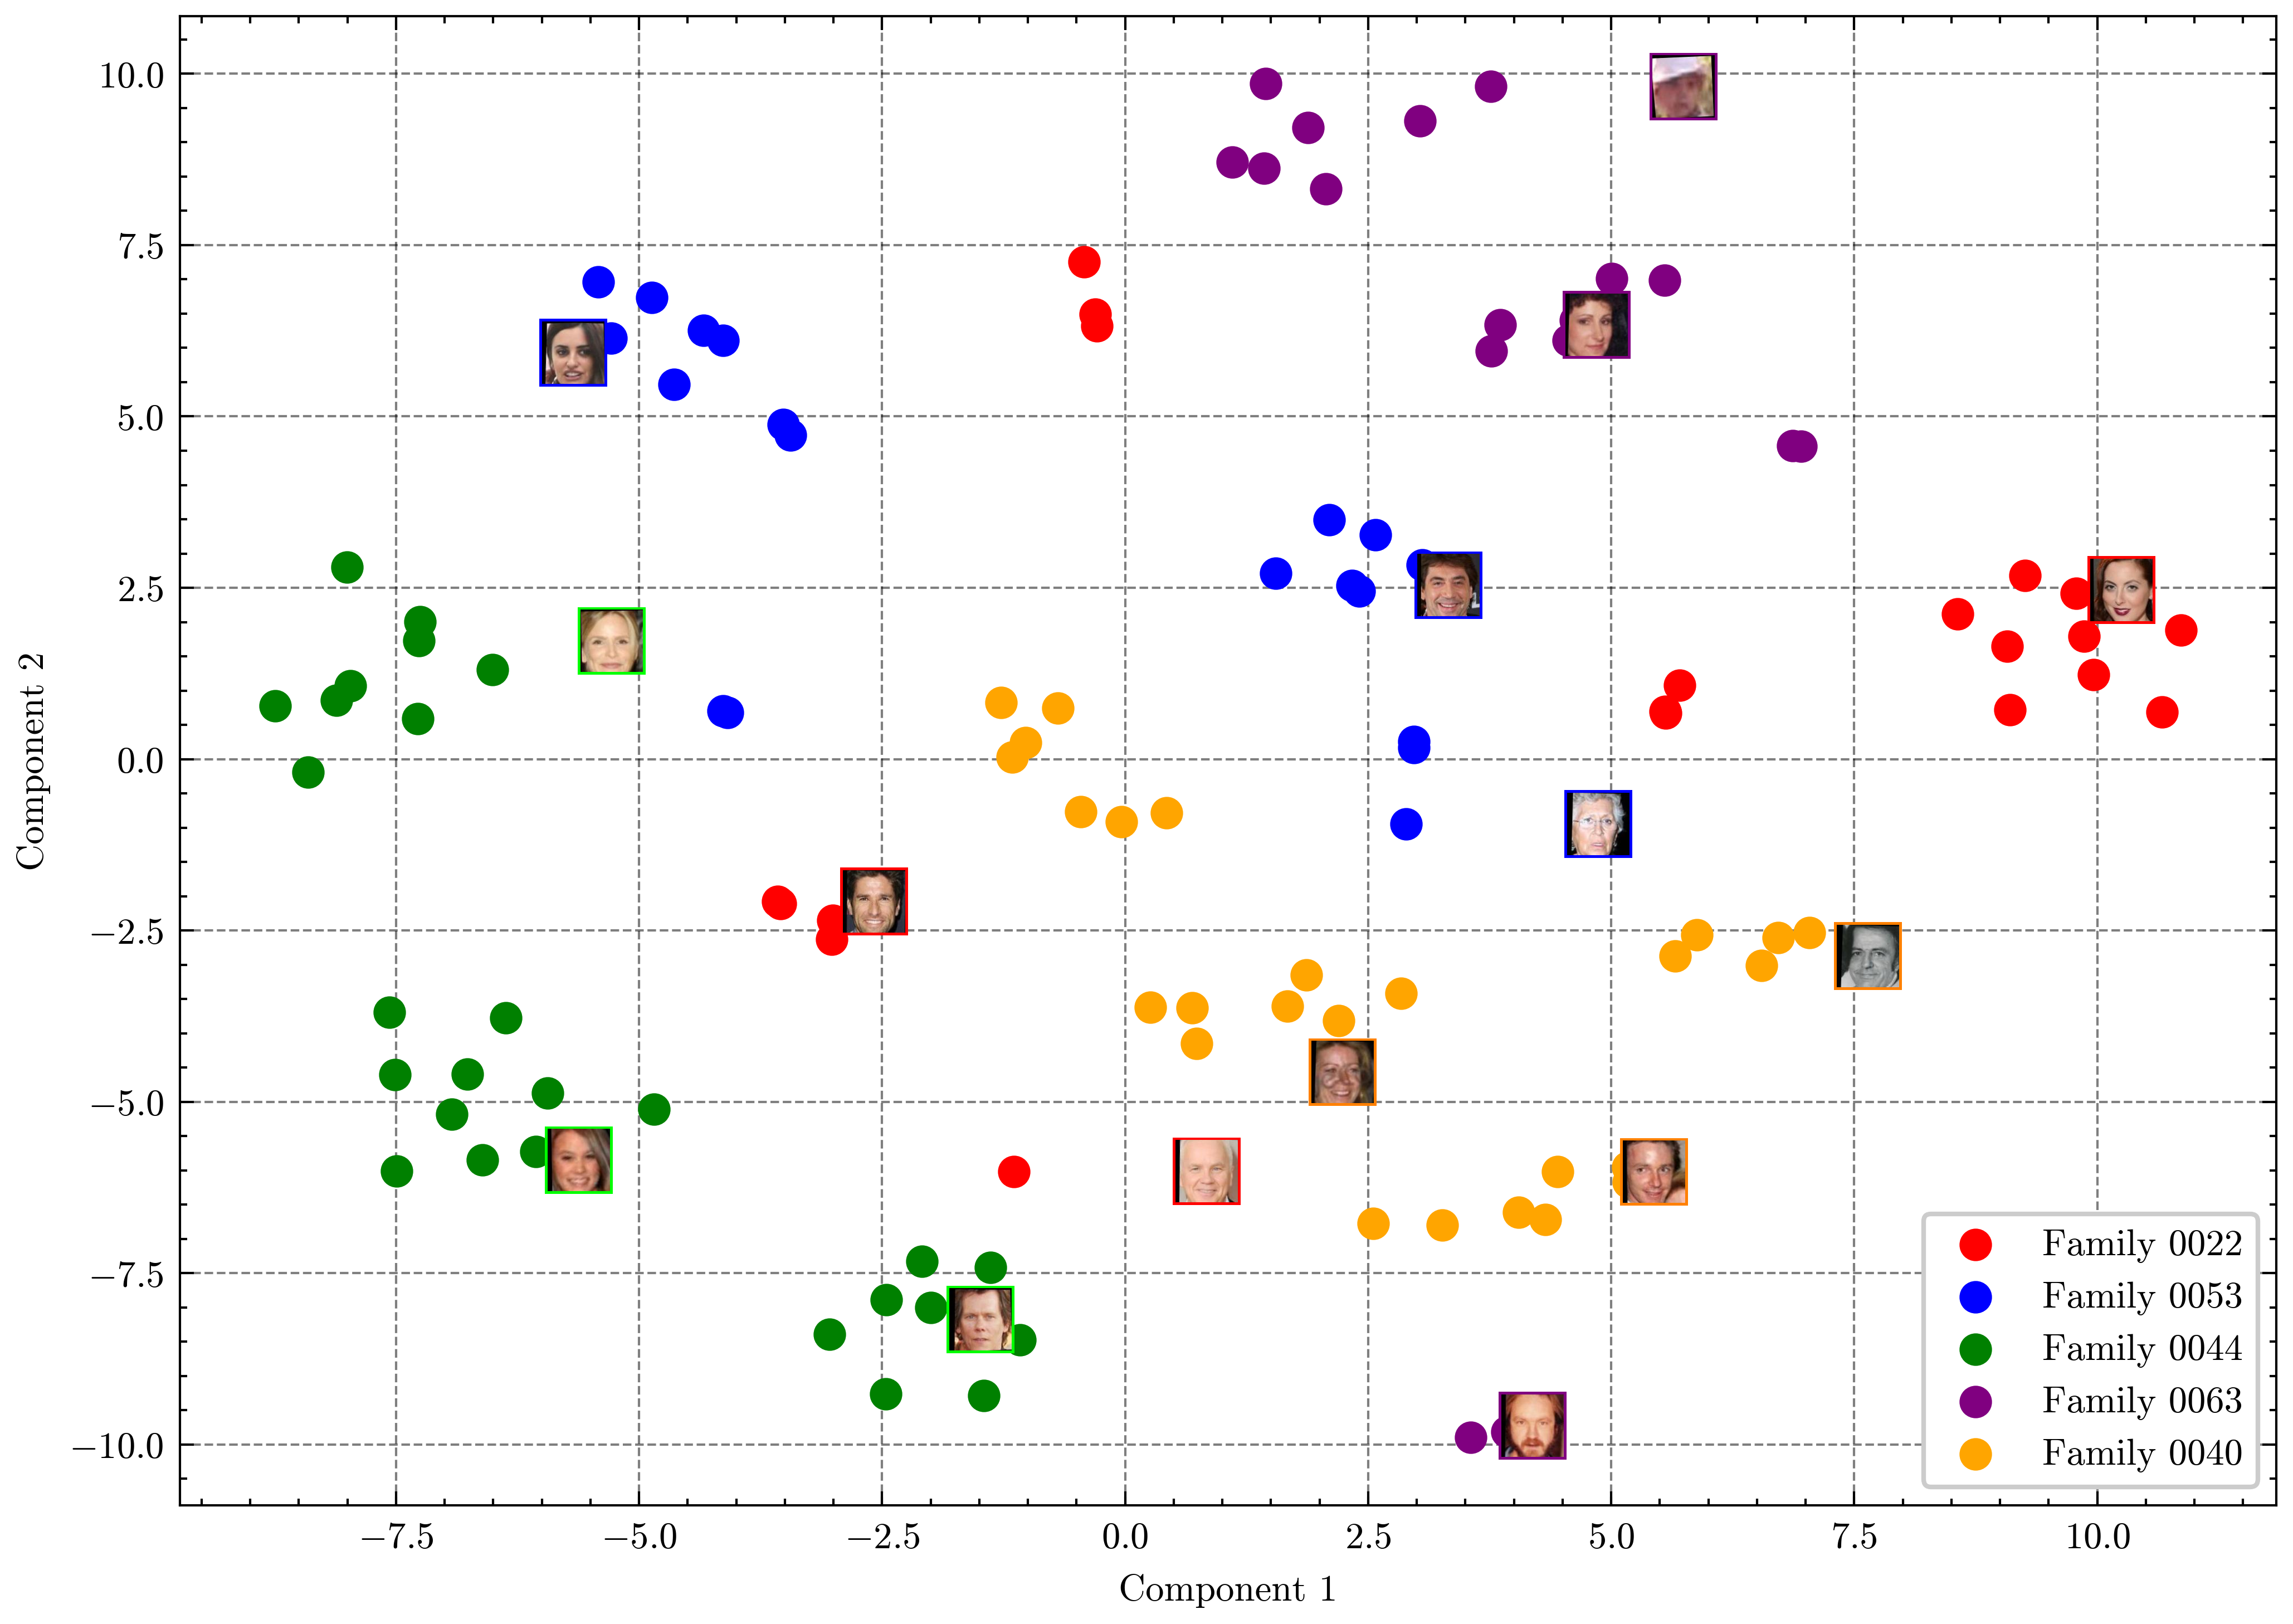

In [40]:
%matplotlib inline
if IS_NOTEBOOK:
    if __name__ == "__main__":
        args = parser()
        run(**vars(args))
else:
    root_dir = Path(HERE, "../datasets/facornet/images/Validation_A/val-faces")
    batch_size = 40
    experiment = "85a4d335a0f5427eaa00539397bdfcb0"
    checkpoint = "7-2.971-1.659-0.876753.ckpt"
    ckpt_path = Path(Path.home(), f".guild/runs/{experiment}/exp/checkpoints/{checkpoint}")
    # ckpt_path = Path(HERE, f"../ours/weights/model_track1.pth")
    plot_path = "plots_experiments/sota_tsne.png"
    model, val_loader = setup(root_dir, ckpt_path, batch_size, samples_per_member=100)
    run(model, val_loader, plot_path)